In [263]:
import pandas as pd
import seaborn as sns
import csv
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

path="dataset.csv"

## DATA CLEANING

To detect automatically the delimiter or separator, it is specified that separator is equal to None to make python find it. See the explanation of sep parameter on:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [188]:
dataset=pd.read_csv(path, sep=None, engine="python")

In [189]:
dataset.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,"23,9975","219,25","22,5","0,2475",0,0,0,0,0,"-157,25",...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,"57,4925","482,75","37,425","0,2475","22,75","9,1","9,1",0,0,"532,25",...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,"16,99","10,25","16,99",0,0,0,0,0,0,"-4,25",...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38,"7,5",38,0,0,0,0,0,0,"-1,5",...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,"55,23","570,5","71,98",0,0,0,0,0,0,"38,5",...,0.0,I,U,U,U,U,U,Y,434.0,1000005


Now, It is necessary to analyse if there is any NaN value. For see the number of NaN values for each attribute is necessary to extend the maximum number of rows that pandas let to show. It is used "with" to do it only for this code block.

In [190]:
print("Dataset size:", dataset.shape)

#Modifying the maximum number of rows that pandas let to show
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   print(dataset.isnull().sum())

Dataset size: (100000, 100)
rev_Mean              357
mou_Mean              357
totmrc_Mean           357
da_Mean               357
ovrmou_Mean           357
ovrrev_Mean           357
vceovr_Mean           357
datovr_Mean           357
roam_Mean             357
change_mou            891
change_rev            891
drop_vce_Mean           0
drop_dat_Mean           0
blck_vce_Mean           0
blck_dat_Mean           0
unan_vce_Mean           0
unan_dat_Mean           0
plcd_vce_Mean           0
plcd_dat_Mean           0
recv_vce_Mean           0
recv_sms_Mean           0
comp_vce_Mean           0
comp_dat_Mean           0
custcare_Mean           0
ccrndmou_Mean           0
cc_mou_Mean             0
inonemin_Mean           0
threeway_Mean           0
mou_cvce_Mean           0
mou_cdat_Mean           0
mou_rvce_Mean           0
owylis_vce_Mean         0
mouowylisv_Mean         0
iwylis_vce_Mean         0
mouiwylisv_Mean         0
peak_vce_Mean           0
peak_dat_Mean           0
mou_peav_M

### DROPS

Attributes dropped:
- ethnic: is not ethical to keep this attribute
- numbcars: almost half of the dataset doesn't have this attribute
- Customer_ID: it has not variance because is unique for each customer
- ownrent, lor, dwlltype, HHstatin, dwllsize: They are NaN on 30% of the dataset

In [191]:
datasetClean=dataset.drop(columns=["ethnic", "numbcars", "Customer_ID", "ownrent", "lor", "dwlltype", "HHstatin", "dwllsize"])
print("Dataset size:", datasetClean.shape)

Dataset size: (100000, 92)


In order to code categorical attributes, object attributes need to be transform.

In [192]:
datasetClean.dtypes

rev_Mean        object
mou_Mean        object
totmrc_Mean     object
da_Mean         object
ovrmou_Mean     object
                ...   
kid6_10         object
kid11_15        object
kid16_17        object
creditcd        object
eqpdays        float64
Length: 92, dtype: object

In [193]:
datasetClean.select_dtypes(include='object').columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'new_cell',
       'crclscod', 'asl_flag', 'totmou', 'totrev', 'adjrev', 'adjmou',
       'avgrev', 'avgmou', 'avgqty', 'prizm_social

Object attributes which are numbers with "," are pass to floats and object with only numbers and more than 2 different numbers are convert to integer.

In [194]:
objectAttributesList = datasetClean.select_dtypes(include='object').columns
#print(objectAttributesList)
for column in objectAttributesList:
   # Looking through all the column to see if there are one string with a number

   if datasetClean[column].str.contains('\d,').any():
      # Casting column from string with "," to float with "."
      datasetClean[column] = datasetClean[column].str.replace(',', '.').astype(float)

   elif datasetClean[column].str.contains('\d+').all() and len(datasetClean[column].unique()) > 2:
      #If the values in the column are numbers and there are not binary, they are not categorical
      datasetClean[column] = datasetClean[column].astype(int)

Now, only remains attributes which are categorical, binaries and labels

In [195]:
datasetClean.select_dtypes(include='object').columns

Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'marital', 'infobase', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

2 test cases:
- Dropping all the samples with NaN values.
- Data insertion to substitute NaN values. Categorical attributes will use mode value and numerical median value.

### DROPPING NAN'S


In [196]:
#dropping all the samples with NaN
dfDropNan=datasetClean.dropna()
print(dfDropNan.shape)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):

   print(dfDropNan.isnull().sum())

(60385, 92)
rev_Mean            0
mou_Mean            0
totmrc_Mean         0
da_Mean             0
ovrmou_Mean         0
ovrrev_Mean         0
vceovr_Mean         0
datovr_Mean         0
roam_Mean           0
change_mou          0
change_rev          0
drop_vce_Mean       0
drop_dat_Mean       0
blck_vce_Mean       0
blck_dat_Mean       0
unan_vce_Mean       0
unan_dat_Mean       0
plcd_vce_Mean       0
plcd_dat_Mean       0
recv_vce_Mean       0
recv_sms_Mean       0
comp_vce_Mean       0
comp_dat_Mean       0
custcare_Mean       0
ccrndmou_Mean       0
cc_mou_Mean         0
inonemin_Mean       0
threeway_Mean       0
mou_cvce_Mean       0
mou_cdat_Mean       0
mou_rvce_Mean       0
owylis_vce_Mean     0
mouowylisv_Mean     0
iwylis_vce_Mean     0
mouiwylisv_Mean     0
peak_vce_Mean       0
peak_dat_Mean       0
mou_peav_Mean       0
mou_pead_Mean       0
opk_vce_Mean        0
opk_dat_Mean        0
mou_opkv_Mean       0
mou_opkd_Mean       0
drop_blk_Mean       0
attempt_Mean        

### INSERTION OF NUMBERS

In [241]:
dfNanSubstituted=datasetClean.copy()

#filling NaN in object categorical attributes
columnCategorical=dfNanSubstituted.select_dtypes(include='object').columns
for column in columnCategorical:
   #Filling with the most common categorical value, the mode
   dfNanSubstituted[column].fillna(dfNanSubstituted[column].mode()[0], inplace=True)

#fillin NaN in not numerical object attributes
notNumericalColumn=dfNanSubstituted.select_dtypes(exclude='object').columns
for column in notNumericalColumn:
   #Filling with the most common categorical value, the mode
   dfNanSubstituted[column].fillna(dfNanSubstituted[column].median(), inplace=True)

#Modifying the maximum number of rows that pandas let to show
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   print(dfNanSubstituted.isnull().sum())

rev_Mean            0
mou_Mean            0
totmrc_Mean         0
da_Mean             0
ovrmou_Mean         0
ovrrev_Mean         0
vceovr_Mean         0
datovr_Mean         0
roam_Mean           0
change_mou          0
change_rev          0
drop_vce_Mean       0
drop_dat_Mean       0
blck_vce_Mean       0
blck_dat_Mean       0
unan_vce_Mean       0
unan_dat_Mean       0
plcd_vce_Mean       0
plcd_dat_Mean       0
recv_vce_Mean       0
recv_sms_Mean       0
comp_vce_Mean       0
comp_dat_Mean       0
custcare_Mean       0
ccrndmou_Mean       0
cc_mou_Mean         0
inonemin_Mean       0
threeway_Mean       0
mou_cvce_Mean       0
mou_cdat_Mean       0
mou_rvce_Mean       0
owylis_vce_Mean     0
mouowylisv_Mean     0
iwylis_vce_Mean     0
mouiwylisv_Mean     0
peak_vce_Mean       0
peak_dat_Mean       0
mou_peav_Mean       0
mou_pead_Mean       0
opk_vce_Mean        0
opk_dat_Mean        0
mou_opkv_Mean       0
mou_opkd_Mean       0
drop_blk_Mean       0
attempt_Mean        0
complete_M

## ATTRIBUTE CATEGORICAL CODIFICATION

Attributes object that remains are categorical. It is printed the name of the attribute and the number of unique values in each attribute. Also, categorical attributes are encoded.

Coding dataset with data insertion:

In [242]:
objectAttributesList = datasetClean.select_dtypes(include='object').columns
categoricalAttributes=[]
for column in objectAttributesList:

   #categorical
   if len(dfNanSubstituted[column].unique()) > 2:
      oneshot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

      #for data insertion test case
      cadena=dfNanSubstituted[column].to_numpy().reshape(-1, 1)
      dataNewColumns=oneshot_encoder.fit_transform(cadena)


      #creation of a list with new names for new coded column
      #The for loop is iterating inside the categories created by the encoder
      categories=oneshot_encoder.categories_[0]
      newColumnNameList=[f'{column}_{cat}' for cat in categories]

      #saving names of categorical columns to calculate correlations after
      categoricalAttributes=categoricalAttributes + newColumnNameList

      newColumns=pd.DataFrame(dataNewColumns, columns=newColumnNameList)

      #adding new columns and dropping categorical column that has been encoded
      dfNanSubstituted=dfNanSubstituted.join(newColumns)
      dfNanSubstituted.drop(columns=column, inplace=True)

   else:
      #binary categorical encode
      encoder = LabelEncoder()
      dfNanSubstituted[column]=encoder.fit_transform(dfNanSubstituted[column])
      #saving names of categorical columns to calculate correlations after
      categoricalAttributes.append(column)


Coding dataset with NaN dropped:

In [199]:
categoricalAttributes = datasetClean.select_dtypes(include='object').columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   print(dfDropNan.isnull().sum())
   print('')
for column in categoricalAttributes:

   #categorical
   if len(dfDropNan[column].unique()) > 2:
      oneshot_encoder2 = OneHotEncoder(sparse=False, handle_unknown='ignore')

      #for data insertion test case
      cadena2=dfDropNan[column].to_numpy().reshape(-1, 1)
      dataNewColumns2=oneshot_encoder2.fit_transform(cadena2)


      #creation of a list with new names for new coded column
      #The for loop is iterating inside the categories created by the encoder
      categories2=oneshot_encoder2.categories_[0]
      newColumnNameList2=[f'{column}_{cat}' for cat in categories2]

      newColumns2=pd.DataFrame(dataNewColumns2, columns=newColumnNameList2)

      #if the index are NOT reset, it will generate rows with nan values
      #because index from dataset and new columns doesn't match
      dfDropNan.reset_index(drop=True, inplace=True)
      newColumns2.reset_index(drop=True, inplace=True)

      #adding new columns and dropping categorical column that has been encoded
      dfDropNan=dfDropNan.join(newColumns2)
      dfDropNan.drop(columns=column, inplace=True)

   else:
      #binary categorical encode
      encoder = LabelEncoder()
      dfDropNan[column]=encoder.fit_transform(dfDropNan[column])


rev_Mean            0
mou_Mean            0
totmrc_Mean         0
da_Mean             0
ovrmou_Mean         0
ovrrev_Mean         0
vceovr_Mean         0
datovr_Mean         0
roam_Mean           0
change_mou          0
change_rev          0
drop_vce_Mean       0
drop_dat_Mean       0
blck_vce_Mean       0
blck_dat_Mean       0
unan_vce_Mean       0
unan_dat_Mean       0
plcd_vce_Mean       0
plcd_dat_Mean       0
recv_vce_Mean       0
recv_sms_Mean       0
comp_vce_Mean       0
comp_dat_Mean       0
custcare_Mean       0
ccrndmou_Mean       0
cc_mou_Mean         0
inonemin_Mean       0
threeway_Mean       0
mou_cvce_Mean       0
mou_cdat_Mean       0
mou_rvce_Mean       0
owylis_vce_Mean     0
mouowylisv_Mean     0
iwylis_vce_Mean     0
mouiwylisv_Mean     0
peak_vce_Mean       0
peak_dat_Mean       0
mou_peav_Mean       0
mou_pead_Mean       0
opk_vce_Mean        0
opk_dat_Mean        0
mou_opkv_Mean       0
mou_opkd_Mean       0
drop_blk_Mean       0
attempt_Mean        0
complete_M

## ATTRIBUTES SELECTION

### CORRELATIONS

Correlations between categorical attributes and categorical attribute churn:

In [243]:
corrCategorical={}
for attribute in categoricalAttributes:
   correlacion, p_valor = pointbiserialr(dfNanSubstituted[attribute], dfNanSubstituted['churn'])
   corrCategorical[attribute]=correlacion
   #print(f"Correlación Punto Biserial para {attribute}: {correlacion:.4f}, p-valor: {p_valor:.4f}")


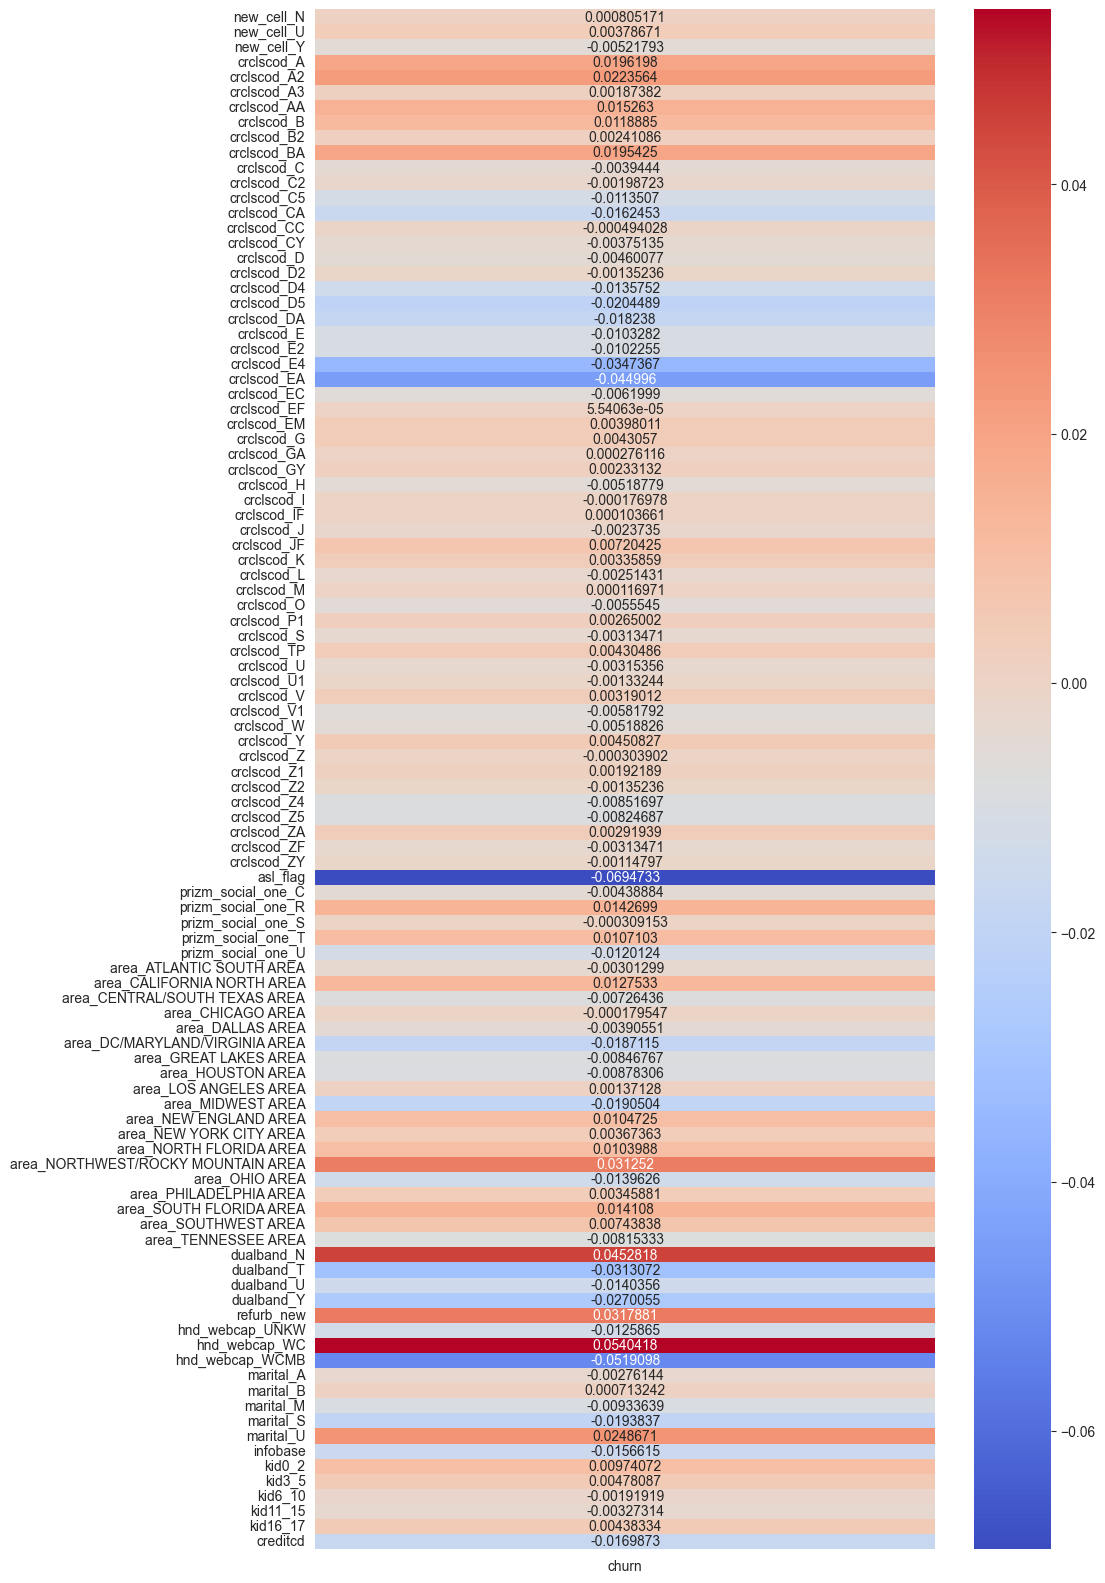

In [246]:
correlationMatrix=pd.DataFrame({"churn":corrCategorical.values()}, index=corrCategorical.keys())

plt.figure(figsize=(10, 20))
sns.heatmap(correlationMatrix, annot=True, fmt="g", cmap='coolwarm')

plt.show()

Correlation between continuous attributes and churn:

In [ ]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))

In [247]:
relevantAttributes={}
nanSubs_X=dfNanSubstituted.drop(columns='churn')
nanSubs_Y=dfNanSubstituted['churn']

thresholdCorrelation=0.3

for column in nanSubs_X.columns:

   #we only calculate cramer_V of not categorical attributes
   if column not in categoricalAttributes:
      corr=cramers_V(nanSubs_X[column], nanSubs_Y)
      print(column, corr)

      if corr > thresholdCorrelation:
         relevantAttributes[column]=corr

rev_Mean 0.6168967185264279
mou_Mean 0.32792095210022365
totmrc_Mean 0.3255188280195528
da_Mean 0.04960018157327528
ovrmou_Mean 0.16785225007749877
ovrrev_Mean 0.3542369412172307
vceovr_Mean 0.27869772771993223
datovr_Mean 0.09230447600077384
roam_Mean 0.23297827677646202
change_mou 0.2957371347869321
change_rev 0.5735430487844441
drop_vce_Mean 0.0681728423758316
drop_dat_Mean 0.02471686083747052
blck_vce_Mean 0.07073648725724471
blck_dat_Mean 0.025963583160501284
unan_vce_Mean 0.11685927018318201
unan_dat_Mean 0.027457424532881195
plcd_vce_Mean 0.18093677636100658
plcd_dat_Mean 0.06935571092787608
recv_vce_Mean 0.14597678837089798
recv_sms_Mean 0.03388543015669717
comp_vce_Mean 0.16434946313220075
comp_dat_Mean 0.06686496041873763
custcare_Mean 0.07127347929014971
ccrndmou_Mean 0.08696370078797225
cc_mou_Mean 0.3056338329459216
inonemin_Mean 0.12332922450175016
threeway_Mean 0.048967462865385725
mou_cvce_Mean 0.8327078220610271
mou_cdat_Mean 0.21256023361703485
mou_rvce_Mean 0.7229120

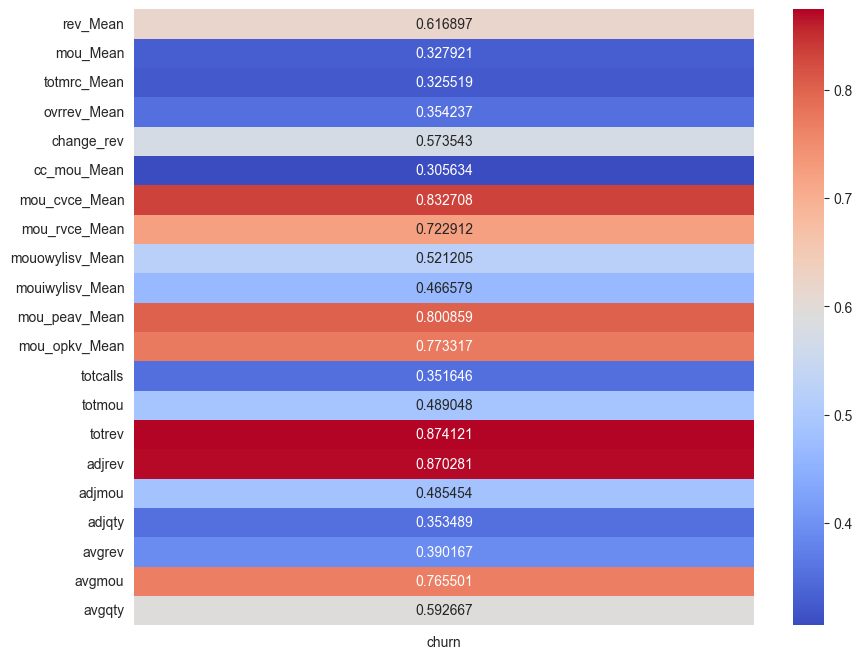

In [248]:
correlationMatrix=pd.DataFrame({"churn":relevantAttributes.values()}, index=relevantAttributes.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(correlationMatrix, annot=True, fmt="g", cmap='coolwarm')

plt.show()


In [236]:
sns.countplot(x='totrev', hue='churn', data=dfNanSubstituted)
plt.title('Distribución de Variable Nominal Binaria por Otra Variable Categórica')
plt.show()

KeyboardInterrupt: 

## MODEL SELECTION
Now we try different models: Logistic regression and Decision tree with selected attributes:

In [251]:
nanSubs_X=dfNanSubstituted[relevantAttributes.keys()]
nanSubs_Y=dfNanSubstituted['churn']

X_train, X_test, Y_train, Y_test = train_test_split(nanSubs_X, nanSubs_Y, test_size=0.8, random_state=42)

### LOGISTIC REGRESSION

In [255]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [256]:
model = LogisticRegression()
model.fit(X_train_scaled,Y_train)
y_pred = model.predict(X_test_scaled)
#Calculating recall, true positives
recall = recall_score(Y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [257]:
print(recall)

0.5828329212292476


## DECISION TREE

In [262]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, Y_train)
y_pred = tree_model.predict(X_test)
recall = recall_score(Y_test, y_pred)
print(recall)

0.5217994651057173


In [265]:
# Crear y entrenar el modelo de Random Forest para clasificación
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

recall = recall_score(Y_test, y_pred)
print(recall)


0.5562143614068729


### PCA

It is necessary to standardize the dataset to use PCA.

In [258]:
#getting the objective attribute from the datasets of the 2 test cases
nanSubs_X=dfNanSubstituted.drop(columns='churn')
nanSubs_Y=dfNanSubstituted['churn']

scaler = StandardScaler()

nanSubs_X_std=scaler.fit_transform(nanSubs_X)

pca = PCA(n_components=2)

nanSubs_X_pca=pca.fit_transform(nanSubs_X)

#Printing results of PCA
print(pca.explained_variance_ratio_)


[0.97282617 0.01982466]


[0.97458178 0.01891456 0.00335143]
Loadings de las características en los primeros componentes principales:
   rev_Mean  mou_Mean  totmrc_Mean   da_Mean  ovrmou_Mean  ovrrev_Mean  \
0  0.001613  0.025057     0.000807  0.000053     0.002592     0.000628   
1 -0.003923 -0.068696    -0.002179 -0.000068    -0.005779    -0.001827   
2 -0.012403 -0.377503    -0.004126 -0.000298    -0.029212    -0.009500   

   vceovr_Mean  datovr_Mean  roam_Mean  change_mou  change_rev  drop_vce_Mean  \
0     0.000620     0.000007   0.000048   -0.002107   -0.000191       0.000270   
1    -0.001798    -0.000028  -0.000232    0.004078    0.000421      -0.000225   
2    -0.009364    -0.000135  -0.000238    0.013901   -0.000999      -0.004213   

   drop_dat_Mean  blck_vce_Mean  blck_dat_Mean  unan_vce_Mean  unan_dat_Mean  \
0       0.000002       0.000139   7.290580e-07       0.001205   8.338652e-07   
1      -0.000003      -0.000165  -2.015430e-06       0.000397  -2.308697e-06   
2      -0.000027      -0.00327

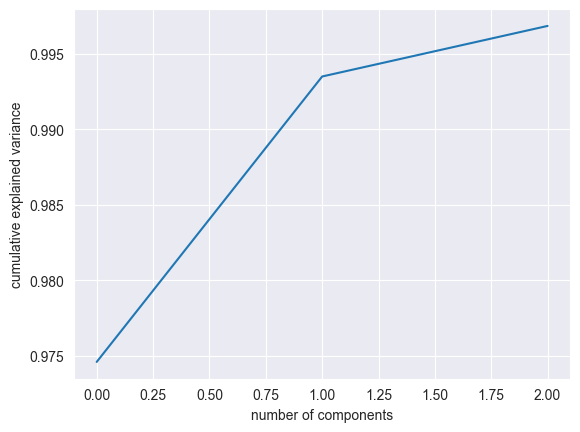

In [260]:
nanDrop_X=dfDropNan.drop(columns='churn')
nanDrop_Y=dfDropNan['churn']
nanDrop_X_std=scaler.fit_transform(nanDrop_X)

pca = PCA(n_components=3)

nanDrop_X_pca=pca.fit_transform(nanDrop_X)

#Printing results of PCA
print(pca.explained_variance_ratio_)

# Obtener los loadings de las características en los primeros componentes principales
loadings = pca.components_

# Obtener nombres de características originales (suponiendo que tienes un DataFrame)
feature_names = list(nanDrop_X.columns)

# Crear un DataFrame para visualizar los loadings junto con los nombres de las características
loadings_df = pd.DataFrame(loadings, columns=feature_names)



# Visualizar el DataFrame de loadings
print("Loadings de las características en los primeros componentes principales:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   print(loadings_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
